# Substructure filters for hit triaging
> Hit triaging code reported from Novartis Institutes for BioMedical Research (NIBR).

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]

## Introduction

Now there are lots of substructure filters for getting drug like molecules such as PAINS, LillyMedChem rules etc. And most of rules are publically available. It's reall great thing.

And recently new filter is disclosed from NIBR. And the rules are provided from rdkit/Contrib/NIBRSubstructureFilters ;)
The LinkURL is below.
https://github.com/rdkit/rdkit/tree/master/Contrib/NIBRSubstructureFilters

The orignal code is command line tool for batch analysis so it is useful for handling SMILES set as CSV format. I'm interested in the code and tried to use it from jupyter notebook.

## Approach

Most of code is borrowed from original repository. And few parts are changed because original code assign molecules in the function. I modified the code and re-defined function for a molecule.
All code is shown below.

## step1

Import required library and define path for requierd data(SMARTS pattern for the filter).

In [1]:
import os
import sys
import pandas as pd
import numpy as np
from rdkit import Chem
nirb_dir = os.path.join('/home/iwatobipen/miniconda3/envs/chemoinfo/share/RDKit/Contrib/NIBRSubstructureFilters/')
sys.path.append(nirb_dir)
from collections import Counter, defaultdict, namedtuple
from rdkit import Chem
from rdkit.Chem import FilterCatalog
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

In [2]:
import assignSubstructureFilters

In [3]:
FilterMatch = namedtuple('FilterMatch', ('SubstructureMatches', 'Min_N_O_filter', 'Frac_N_O', 'Covalent', 'SpecialMol', 'SeverityScore'))

# Build the filter catalog using the RDKit filterCatalog module
def buildFilterCatalog():

    inhousefilter = pd.read_csv(os.path.join(nirb_dir,'SubstructureFilter_HitTriaging_wPubChemExamples.csv'))
    inhouseFiltersCat = FilterCatalog.FilterCatalog()
    for i in range(inhousefilter.shape[0]):
        mincount=1
        if inhousefilter['MIN_COUNT'][i] != 0:
            mincount = int(inhousefilter['MIN_COUNT'][i]) 
        pname = inhousefilter['PATTERN_NAME'][i]
        sname = inhousefilter['SET_NAME'][i]
        pname_final='{0}_min({1})__{2}__{3}__{4}'.format(pname,mincount,
                                                    inhousefilter['SEVERITY_SCORE'][i],
                                                    inhousefilter['COVALENT'][i],
                                                    inhousefilter['SPECIAL_MOL'][i])
        fil = FilterCatalog.SmartsMatcher(pname_final,inhousefilter['SMARTS'][i], mincount)
        inhouseFiltersCat.AddEntry(FilterCatalog.FilterCatalogEntry(pname_final,fil))
        inhouseFiltersCat.GetEntry(i).SetProp('Scope', sname)
    return inhouseFiltersCat

In [4]:
def assignFilters(mol):
 
    results=[]
    
    inhouseFiltersCat = buildFilterCatalog()
    
    NO_filter = '[#7,#8]'    
    sma = Chem.MolFromSmarts(NO_filter, mergeHs=True)
    
    qc,NO_filter,fracNO,co,sc,sm = [np.NaN]*6

    # fraction of N and O atoms
    numHeavyAtoms = mol.GetNumHeavyAtoms()
    numNO = len(mol.GetSubstructMatches(Chem.MolFromSmarts('[#7,#8]')))
    fracNO = float(numNO)/numHeavyAtoms

    # all substructure filters
    entries = inhouseFiltersCat.GetMatches(mol)
    if len(list(entries)):
        # initialize empty lists
        fs,sev,cov,spm = ([] for _ in range(4))
        # get the matches
        for entry in entries:
            pname=entry.GetDescription()
            n, s, c, m = pname.split('__')           
            fs.append(entry.GetProp("Scope")+'_'+n)
            sev.append(int(s))
            cov.append(int(c))
            spm.append(int(m))
        # concatenate all matching filters
        qc = ' | '.join(fs)
        # assign overall severity
        if sev.count(2):
            sc = 10
        else:
            sc = sum(sev)
        # get number of covalent flags and special molecule flags
        co = sum(cov)
        sm = sum(spm)
    # if non of the filters matches
    else:
        qc = 'no match'
        sc = 0
        co = 0
        sm = 0

    # special NO filter
    if not mol.HasSubstructMatch(sma):
        NO_filter = 'no_oxygen_or_nitrogen'
    else:
        NO_filter = 'no match'
    res = FilterMatch(qc,NO_filter,fracNO,co,sm,sc)
    return res

Now almost there. Let's check the code. Following molecules are came from original repo.

In [17]:
m1 = Chem.MolFromSmiles('Fc1ccc(c(Cl)c1Cl)n2nnnc2Cc3cccnc3')
m2 = Chem.MolFromSmiles('[O-][N+](=O)c1ccc(cc1)C(=O)Oc2cccc3oc(cc23)c4ccccc4')

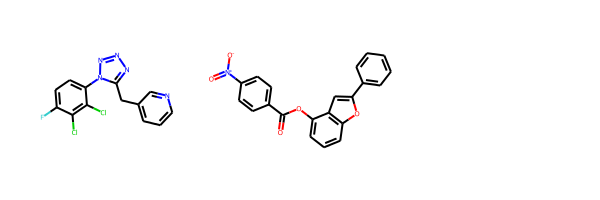

In [18]:
Draw.MolsToGridImage([m1, m2])

In [19]:
res1 = assignFilters(m1)
res2 = assignFilters(m2)

In [20]:
print(res1)
print(res2)

FilterMatch(SubstructureMatches='NIBR_Screeningdeck_2019_halogen_aromatic_count_3_min(3) | NIBR_Screeningdeck_2019_polyhalogenated_aromate_min(1)', Min_N_O_filter='no match', Frac_N_O=0.23809523809523808, Covalent=0, SpecialMol=0, SeverityScore=1)
FilterMatch(SubstructureMatches='NIBR_Screeningdeck_2019_nitro_count_1_min(1) | NIBR_Screeningdeck_2019_phenol_ester_min(1)', Min_N_O_filter='no match', Frac_N_O=0.2222222222222222, Covalent=0, SpecialMol=0, SeverityScore=0)


As you can see, running the code on jupyter, we can get molecule with highlight atoms.

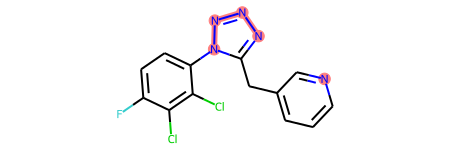

In [21]:
m1

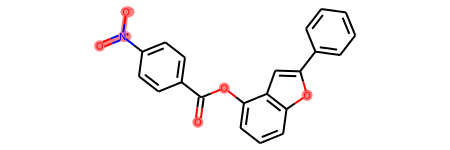

In [22]:
m2

## Summary

By using the code from jupyter notebook, it's easy to see the atoms which are meet the filter.
RDKit Contrib folder has lots of useful code for chemoinformatics! Don't miss it!!!!